In [11]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import warnings

#Astrazeneca GRU-SGD

In [81]:
df = pd.read_excel('/content/drive/MyDrive/Astrazeneca.xlsx')
df = df[~df['Comments'].isnull()]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df['tag']= df['tag'].fillna(4)
df_untagged = df[df['tag'] == 4]
df = df[df['tag'] != 4]
df

,Name,Comments,tag
0,galannxceepta,Sarah gilbert melepas hak paten vaksin astraze...,positif
1,mas_bar35,Apakah dia lulusan UI yg ada komisarisnya itu,netral
2,m.taufik4671,"Vaksin nusantara ga ada cuannya, makanya ga di...",netral
3,indraadityalukman,Saya indra. Bukan satpol,netral
4,ismailmarzuki19,Marketingnya bagus ni,negatif
...,...,...,...
446,pejuangrakyat6880,Di fikir siapa kali bisa cegah kematian 😂 mau ...,negatif
447,danuandiyanto,"Dulu dihina, sekarang dipuja.",netral
448,bayulejing,Gak covid gak ad vansin..Tuhan bilang Mati ya ...,negatif
449,undefeatedkid,Tempo jadi sales 😂😂😂,negatif


In [82]:
df_untagged = df_untagged.reset_index()
df_untagged = df_untagged.drop(['index'], axis=1)
df_untagged

,Name,Comments,tag
0,jhaunceryl27,Luar Biasa,4
1,jajat_7uansyah,"Bangga dan saluutt @rudianindra , sukses dan b...",4
2,zulkiplimuhtar,Adiknya Mira ya @maulidalbia ?,4
3,yuhartini17,👏😍,4
4,aswadsabirin,❤️👍👍,4
...,...,...,...
196,stevy.agnes,@will_iam_sutanto @wawan_lo,4
197,agatha_kristiastutitananta,Untuk vaksin sinoparm bgmn kk?,4
198,ninda_kania,Min...ibu menyusui boleh vaksin ini gk y?,4
199,nanank3,brarti nunggu 12 minggu antibodinya aktif ?,4


In [83]:
print(df.tag.value_counts())

netral     119
negatif     73
positif     58
Name: tag, dtype: int64


In [7]:
df['POS']= np.where(df['tag'] == 'positif', '1', '0')
df['NET']= np.where(df['tag'] == 'netral', '1', '0')
df['NEG']= np.where(df['tag'] == 'negatif', '1', '0')
df = df.drop(['tag'], axis=1)
df

,Name,Comments,POS,NET,NEG
0,galannxceepta,Sarah gilbert melepas hak paten vaksin astraze...,1,0,0
1,mas_bar35,Apakah dia lulusan UI yg ada komisarisnya itu,0,1,0
2,m.taufik4671,"Vaksin nusantara ga ada cuannya, makanya ga di...",0,1,0
3,indraadityalukman,Saya indra. Bukan satpol,0,1,0
4,ismailmarzuki19,Marketingnya bagus ni,0,0,1
...,...,...,...,...,...
446,pejuangrakyat6880,Di fikir siapa kali bisa cegah kematian 😂 mau ...,0,0,1
447,danuandiyanto,"Dulu dihina, sekarang dipuja.",0,1,0
448,bayulejing,Gak covid gak ad vansin..Tuhan bilang Mati ya ...,0,0,1
449,undefeatedkid,Tempo jadi sales 😂😂😂,0,0,1


In [8]:
#ilangin link dan uname
df["Comments"]=df["Comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["Comments"]=df["Comments"].str.lower()
#ilangin simbol
df["Comments"]=df["Comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df["Comments"]=df["Comments"].str.replace('\d+',' ')
#ilangin enter
df["Comments"]=df["Comments"].str.replace('\n',' ',regex=True)
df["Comments"] = df["Comments"].replace('\s+', ' ', regex=True)
df

,Name,Comments,POS,NET,NEG
0,galannxceepta,sarah gilbert melepas hak paten vaksin astraze...,1,0,0
1,mas_bar35,apakah dia lulusan ui yg ada komisarisnya itu,0,1,0
2,m.taufik4671,vaksin nusantara ga ada cuannya makanya ga di ...,0,1,0
3,indraadityalukman,saya indra bukan satpol,0,1,0
4,ismailmarzuki19,marketingnya bagus ni,0,0,1
...,...,...,...,...,...
446,pejuangrakyat6880,di fikir siapa kali bisa cegah kematian mau ng...,0,0,1
447,danuandiyanto,dulu dihina sekarang dipuja,0,1,0
448,bayulejing,gak covid gak ad vansin tuhan bilang mati ya m...,0,0,1
449,undefeatedkid,tempo jadi sales,0,0,1


In [9]:
df_majority = df[df.POS== '0' ]

df_minority = df[df.POS== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=119,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.NEG== '0' ]

df_minority_2 = df_upsampled[df_upsampled.NEG== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=119,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df = df_upsampled_2
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0    238
1    119
Name: POS, dtype: int64
0    238
1    119
Name: NET, dtype: int64
0    238
1    119
Name: NEG, dtype: int64


In [12]:
df['POS']=df['POS'].astype(int)
df['NET']=df['NET'].astype(int)
df['NEG']=df['NEG'].astype(int)
train, test = train_test_split(df, test_size=0.2, random_state = 23)
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comments"]
list_sentences_test = test["Comments"]
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [13]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [14]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [15]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin",binary="True", unicode_errors='ignore')
word2vec = word_vectors
embed_dim = 300

In [16]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

1324 166
known words: 1324
unknown words: 166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [17]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
inp = Input(shape=(maxlen,))


In [ ]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 - 5s - loss: 0.6712 - accuracy: 0.3298 - val_loss: 0.6525 - val_accuracy: 0.2500

 ROC-AUC - epoch: 1 - score: 0.508977 

Epoch 2/100
9/9 - 1s - loss: 0.6611 - accuracy: 0.3649 - val_loss: 0.6466 - val_accuracy: 0.2917

 ROC-AUC - epoch: 2 - score: 0.511549 

Epoch 3/100
9/9 - 2s - loss: 0.6689 - accuracy: 0.3404 - val_loss: 0.6429 - val_accuracy: 0.3056

 ROC-AUC - epoch: 3 - score: 0.526286 

Epoch 4/100
9/9 - 2s - loss: 0.6420 - accuracy: 0.3860 - val_loss: 0.6420 - val_accuracy: 0.2778

 ROC-AUC - epoch: 4 - score: 0.535975 

Epoch 5/100
9/9 - 2s - loss: 0.6498 - accuracy: 0.3789 - val_loss: 0.6373 - val_accuracy: 0.3750

 ROC-AUC - epoch: 5 - score: 0.550764 

Epoch 6/100
9/9 - 1s - loss: 0.6355 - accuracy: 0.4281 - val_loss: 0.6324 - val_accuracy: 0.3333

 ROC-AUC - epoch: 6 - score: 0.564777 

Epoch 7/100
9/9 - 2s - loss: 0.6401 - accuracy: 0.4386 - val_loss: 0.6285 - val_accuracy: 0.3750

 ROC-AUC - epoch: 7 - score: 0.581353 

Epoch 8/100
9/9 - 1s - loss: 0.625

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 300)           447300    
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 200)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0   

In [ ]:
from keras.models import load_model
c = model.predict(X_te)

In [ ]:

score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 44ms/step - loss: 0.3479 - accuracy: 0.7778
Test accuracy: 0.7777777910232544


In [ ]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.9200710033726338

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

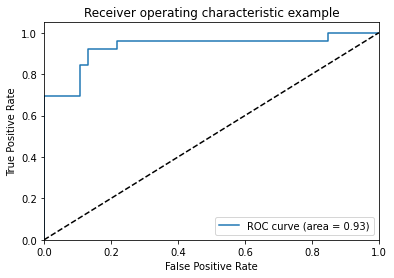

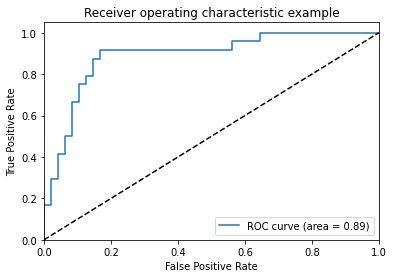

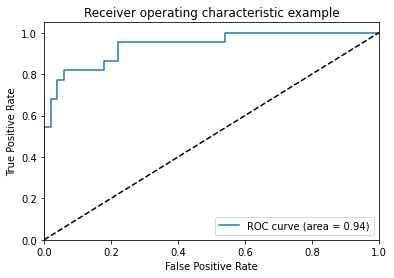

In [ ]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)


0.8621460001351305

In [ ]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[38  8]
  [ 2 24]]

 [[39  9]
  [ 2 22]]

 [[37 13]
  [ 1 21]]]
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        26
           1       0.71      0.92      0.80        24
           2       0.62      0.95      0.75        22

   micro avg       0.69      0.93      0.79        72
   macro avg       0.69      0.93      0.79        72
weighted avg       0.70      0.93      0.79        72
 samples avg       0.76      0.93      0.82        72



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.7638888888888888


In [ ]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.5972222222222222
Hamming loss: 0.16203703703703703


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[24,  1,  1],
       [ 7, 17,  0],
       [ 1,  6, 15]])

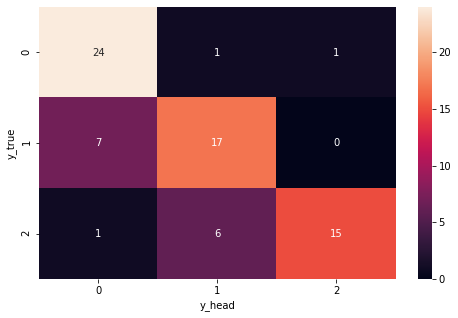

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

#Astrazeneca LSTM-ADAM

In [18]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = LSTM(200, activation='tanh', return_sequences = True, dropout=0.4)(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 - 24s - loss: 0.6838 - accuracy: 0.3895 - val_loss: 0.6628 - val_accuracy: 0.4028

 ROC-AUC - epoch: 1 - score: 0.607231 

Epoch 2/100
9/9 - 2s - loss: 0.6537 - accuracy: 0.3789 - val_loss: 0.6148 - val_accuracy: 0.4167

 ROC-AUC - epoch: 2 - score: 0.642553 

Epoch 3/100
9/9 - 2s - loss: 0.6257 - accuracy: 0.4316 - val_loss: 0.6107 - val_accuracy: 0.4861

 ROC-AUC - epoch: 3 - score: 0.685944 

Epoch 4/100
9/9 - 2s - loss: 0.5917 - accuracy: 0.5228 - val_loss: 0.6028 - val_accuracy: 0.4722

 ROC-AUC - epoch: 4 - score: 0.705323 

Epoch 5/100
9/9 - 2s - loss: 0.5802 - accuracy: 0.5649 - val_loss: 0.5619 - val_accuracy: 0.5833

 ROC-AUC - epoch: 5 - score: 0.776066 

Epoch 6/100
9/9 - 2s - loss: 0.5412 - accuracy: 0.6035 - val_loss: 0.5510 - val_accuracy: 0.5833

 ROC-AUC - epoch: 6 - score: 0.795525 

Epoch 7/100
9/9 - 2s - loss: 0.4827 - accuracy: 0.6982 - val_loss: 0.5129 - val_accuracy: 0.5833

 ROC-AUC - epoch: 7 - score: 0.803142 

Epoch 8/100
9/9 - 2s - loss: 0.41

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           447300    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 200)           400800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

In [20]:
from keras.models import load_model
c = model.predict(X_te)

In [21]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 44ms/step - loss: 0.8339 - accuracy: 0.8056
Test accuracy: 0.8055555820465088


In [22]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.9436309760086935

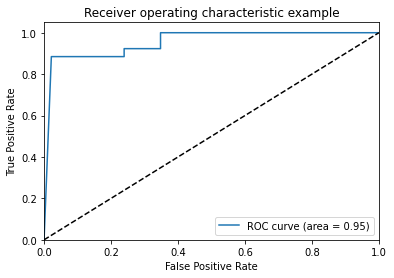

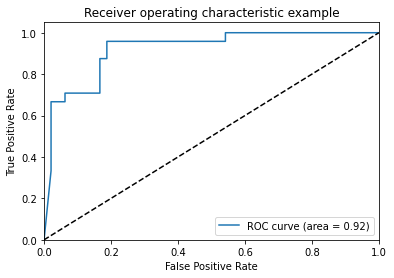

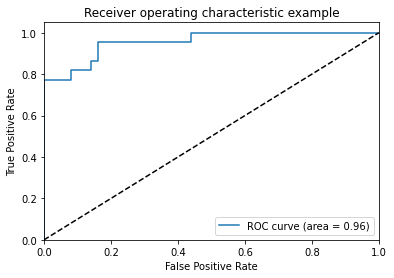

In [23]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [24]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)



0.84895324482281

In [25]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[42  4]
  [ 3 23]]

 [[40  8]
  [ 6 18]]

 [[47  3]
  [ 5 17]]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.69      0.75      0.72        24
           2       0.85      0.77      0.81        22

   micro avg       0.79      0.81      0.80        72
   macro avg       0.80      0.80      0.80        72
weighted avg       0.80      0.81      0.80        72
 samples avg       0.80      0.81      0.80        72



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.7916666666666666


In [26]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.7916666666666666
Hamming loss: 0.13425925925925927


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[23,  3,  0],
       [ 4, 18,  2],
       [ 0,  5, 17]])

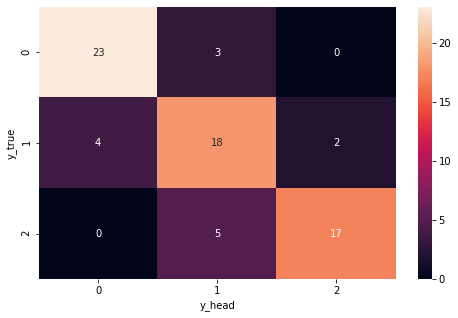

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [30]:
df_untagged = df_untagged.drop(['tag'], axis =1)
df_untagged

,Name,Comments
0,jhaunceryl27,Luar Biasa
1,jajat_7uansyah,"Bangga dan saluutt @rudianindra , sukses dan b..."
2,zulkiplimuhtar,Adiknya Mira ya @maulidalbia ?
3,yuhartini17,👏😍
4,aswadsabirin,❤️👍👍
...,...,...
196,stevy.agnes,@will_iam_sutanto @wawan_lo
197,agatha_kristiastutitananta,Untuk vaksin sinoparm bgmn kk?
198,ninda_kania,Min...ibu menyusui boleh vaksin ini gk y?
199,nanank3,brarti nunggu 12 minggu antibodinya aktif ?


In [31]:
#ilangin link dan uname
df_untagged["Comments"]=df_untagged["Comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df_untagged["Comments"]=df_untagged["Comments"].str.lower()
#ilangin simbol
df_untagged["Comments"]=df_untagged["Comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df_untagged["Comments"]=df_untagged["Comments"].str.replace('\d+',' ')
#ilangin enter
df_untagged["Comments"]=df_untagged["Comments"].str.replace('\n',' ',regex=True)
df_untagged["Comments"] = df_untagged["Comments"].replace('\s+', ' ', regex=True)
df_untagged

,Name,Comments
0,jhaunceryl27,luar biasa
1,jajat_7uansyah,bangga dan saluutt sukses dan berkah ilmu mu n...
2,zulkiplimuhtar,adiknya mira ya
3,yuhartini17,
4,aswadsabirin,
...,...,...
196,stevy.agnes,
197,agatha_kristiastutitananta,untuk vaksin sinoparm bgmn kk
198,ninda_kania,min ibu menyusui boleh vaksin ini gk y
199,nanank3,brarti nunggu minggu antibodinya aktif


In [33]:
list_sentences_aplikasi = df_untagged["Comments"]
list_tokenized_aplikasi = tokenizer.texts_to_sequences(list_sentences_aplikasi)
X_aplikasi = pad_sequences(list_tokenized_aplikasi, maxlen=maxlen)
X_aplikasi

array([[   0,    0,    0, ...,    0,  199,  242],
       [   0,    0,    0, ...,    4,    4, 1121],
       [   0,    0,    0, ...,    0,    0,   20],
       ...,
       [   0,    0,    0, ...,    1,   11,  247],
       [   0,    0,    0, ...,    0,    0,  453],
       [   0,    0,    0, ...,  812,  812,    1]], dtype=int32)

In [34]:
y_pred_aplikasi = model.predict(X_aplikasi)
y_pred_aplikasi


array([[9.57484687e-08, 9.99999762e-01, 1.42582920e-07],
       [4.71402251e-10, 1.00000000e+00, 2.27714042e-10],
       [1.11780849e-07, 9.99999762e-01, 1.11549973e-07],
       [7.48271668e-06, 9.99980927e-01, 1.15700886e-05],
       [7.48271668e-06, 9.99980927e-01, 1.15700886e-05],
       [7.38325127e-07, 9.99998689e-01, 6.40800920e-07],
       [1.93650976e-06, 9.58850503e-01, 4.11476195e-02],
       [1.93832984e-05, 9.99973536e-01, 7.04437616e-06],
       [7.48271668e-06, 9.99980927e-01, 1.15700886e-05],
       [7.48271668e-06, 9.99980927e-01, 1.15700886e-05],
       [3.60702374e-03, 9.93696988e-01, 2.69592647e-03],
       [7.38325127e-07, 9.99998689e-01, 6.40800920e-07],
       [7.48271668e-06, 9.99980927e-01, 1.15700886e-05],
       [7.48271668e-06, 9.99980927e-01, 1.15700886e-05],
       [1.25021601e-04, 9.99374926e-01, 5.00154914e-04],
       [2.99218555e-05, 1.37612980e-04, 9.99832392e-01],
       [1.01247142e-05, 9.99597609e-01, 3.92229034e-04],
       [7.48271668e-06, 9.99980

In [35]:
dfhasil = pd.DataFrame(y_pred_aplikasi, columns=['POS', 'NET', 'NEG'])
dfhasil

,POS,NET,NEG
0,9.574847e-08,1.000000,1.425829e-07
1,4.714023e-10,1.000000,2.277140e-10
2,1.117808e-07,1.000000,1.115500e-07
3,7.482717e-06,0.999981,1.157009e-05
4,7.482717e-06,0.999981,1.157009e-05
...,...,...,...
196,7.482717e-06,0.999981,1.157009e-05
197,5.743092e-05,0.999763,1.798943e-04
198,2.982645e-10,1.000000,9.356562e-12
199,3.332462e-10,1.000000,2.048673e-10


In [36]:
dfhasilramal = dfhasil.eq(dfhasil.where(dfhasil != 0).max(1), axis=0).astype(int)
dfhasilramal

,POS,NET,NEG
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
196,0,1,0
197,0,1,0
198,0,1,0
199,0,1,0


In [37]:
finalresult = pd.concat([df_untagged, dfhasilramal], axis=1, sort=False)
finalresult

,Name,Comments,POS,NET,NEG
0,jhaunceryl27,luar biasa,0,1,0
1,jajat_7uansyah,bangga dan saluutt sukses dan berkah ilmu mu n...,0,1,0
2,zulkiplimuhtar,adiknya mira ya,0,1,0
3,yuhartini17,,0,1,0
4,aswadsabirin,,0,1,0
...,...,...,...,...,...
196,stevy.agnes,,0,1,0
197,agatha_kristiastutitananta,untuk vaksin sinoparm bgmn kk,0,1,0
198,ninda_kania,min ibu menyusui boleh vaksin ini gk y,0,1,0
199,nanank3,brarti nunggu minggu antibodinya aktif,0,1,0


In [38]:
finalresult.POS.value_counts()

0    184
1     17
Name: POS, dtype: int64

In [39]:
finalresult.NET.value_counts()

1    152
0     49
Name: NET, dtype: int64

In [40]:
finalresult.NEG.value_counts()

0    169
1     32
Name: NEG, dtype: int64

#Sinovac GRU-SGD

In [41]:
df = pd.read_excel('/content/drive/MyDrive/Sinovac.xlsx')
df = df[~df['Comments'].isnull()]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df['tag']= df['tag'].fillna(4)
df_untagged = df[df['tag'] == 4]
df = df[df['tag'] != 4]
df = df.reset_index()
df = df.drop(['index', 'Unnamed: 0'], axis=1)
df

,Name,Comments,tag
0,andiewiduri,Hamil?? Usia dbwah 18 ??,netral
1,arisentotwibowo,buat anak koq coba coba,negatif
2,jove1605,Bisa minta info untuk di Bali bisa VAKSIN dima...,positif
3,laurentiawidiawati,"Kagok siade di 11thn, cuma dia aja sendiri dr ...",netral
4,etre_sofia,"Daerah lain door to door vaksinasi, ada vaksin...",positif
...,...,...,...
251,najam_jore,"Pada takut amat si aneh, UEA & NEGARA ARAB LAI...",positif
252,ekky_indra,Gk ada foto lain dan lebih kredibel selain itu...,netral
253,romasikumbang,Halal bukan berarti memaksa untuk di vaksin ya...,negatif
254,labib_zahranisme,Gampang nuntut di akhirat gue mah,negatif


In [42]:
df_untagged = df_untagged.reset_index()
df_untagged = df_untagged.drop(['index', 'Unnamed: 0'], axis=1)
df_untagged

,Name,Comments,tag
0,ica_risa18,@indriaelvandria bacee,4
1,djulkifli_,Aku tak ngguyu mbek turu😂😂😂😄😄,4
2,bagja.rki,@chaeny_shoftyani,4
3,pentolisme,@slebewwww @ripalbendot,4
4,ar_balance01,@randyahmd22,4
...,...,...,...
517,_balaa._syahiddtu,halal blm tentu baik ?,4
518,tomijumaesa,Masyarakat Cina di vaksin gk sih min???,4
519,07_arif,kita sinovac sendiri lohh? beranii? 🤣,4
520,arisadwicahyo,"Emang udah tau bahan dalem nya apa aja😁,dibuat...",4


In [43]:
print(df.tag.value_counts())

negatif    114
netral      81
positif     61
Name: tag, dtype: int64


In [44]:
df['POS']= np.where(df['tag'] == 'positif', '1', '0')
df['NET']= np.where(df['tag'] == 'netral', '1', '0')
df['NEG']= np.where(df['tag'] == 'negatif', '1', '0')
df = df.drop(['tag'], axis=1)
df

,Name,Comments,POS,NET,NEG
0,andiewiduri,Hamil?? Usia dbwah 18 ??,0,1,0
1,arisentotwibowo,buat anak koq coba coba,0,0,1
2,jove1605,Bisa minta info untuk di Bali bisa VAKSIN dima...,1,0,0
3,laurentiawidiawati,"Kagok siade di 11thn, cuma dia aja sendiri dr ...",0,1,0
4,etre_sofia,"Daerah lain door to door vaksinasi, ada vaksin...",1,0,0
...,...,...,...,...,...
251,najam_jore,"Pada takut amat si aneh, UEA & NEGARA ARAB LAI...",1,0,0
252,ekky_indra,Gk ada foto lain dan lebih kredibel selain itu...,0,1,0
253,romasikumbang,Halal bukan berarti memaksa untuk di vaksin ya...,0,0,1
254,labib_zahranisme,Gampang nuntut di akhirat gue mah,0,0,1


In [45]:
#ilangin link dan uname
df["Comments"]=df["Comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["Comments"]=df["Comments"].str.lower()
#ilangin simbol
df["Comments"]=df["Comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df["Comments"]=df["Comments"].str.replace('\d+',' ')
#ilangin enter
df["Comments"]=df["Comments"].str.replace('\n',' ',regex=True)
df["Comments"] = df["Comments"].replace('\s+', ' ', regex=True)
df

,Name,Comments,POS,NET,NEG
0,andiewiduri,hamil usia dbwah,0,1,0
1,arisentotwibowo,buat anak koq coba coba,0,0,1
2,jove1605,bisa minta info untuk di bali bisa vaksin dima...,1,0,0
3,laurentiawidiawati,kagok siade di thn cuma dia aja sendiri dr org...,0,1,0
4,etre_sofia,daerah lain door to door vaksinasi ada vaksina...,1,0,0
...,...,...,...,...,...
251,najam_jore,pada takut amat si aneh uea negara arab lainny...,1,0,0
252,ekky_indra,gk ada foto lain dan lebih kredibel selain itu...,0,1,0
253,romasikumbang,halal bukan berarti memaksa untuk di vaksin ya...,0,0,1
254,labib_zahranisme,gampang nuntut di akhirat gue mah,0,0,1


In [46]:
df_majority = df[df.POS== '0' ]

df_minority = df[df.POS== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=114,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.NET== '0' ]

df_minority_2 = df_upsampled[df_upsampled.NET== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=114,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df = df_upsampled_2
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0    228
1    114
Name: POS, dtype: int64
0    228
1    114
Name: NET, dtype: int64
0    228
1    114
Name: NEG, dtype: int64


In [47]:
df['POS']=df['POS'].astype(int)
df['NET']=df['NET'].astype(int)
df['NEG']=df['NEG'].astype(int)
train, test = train_test_split(df, test_size=0.2, random_state = 23)
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comments"]
list_sentences_test = test["Comments"]
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [48]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [49]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [50]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin",binary="True", unicode_errors='ignore')
word2vec = word_vectors
embed_dim = 300

In [51]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

970 158
known words: 970
unknown words: 158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [52]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
inp = Input(shape=(maxlen,))


In [ ]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 - 5s - loss: 0.7420 - accuracy: 0.3700 - val_loss: 0.6623 - val_accuracy: 0.4493

 ROC-AUC - epoch: 1 - score: 0.557420 

Epoch 2/100
9/9 - 1s - loss: 0.6778 - accuracy: 0.3516 - val_loss: 0.6325 - val_accuracy: 0.4493

 ROC-AUC - epoch: 2 - score: 0.604752 

Epoch 3/100
9/9 - 2s - loss: 0.6563 - accuracy: 0.3993 - val_loss: 0.6225 - val_accuracy: 0.5217

 ROC-AUC - epoch: 3 - score: 0.643097 

Epoch 4/100
9/9 - 2s - loss: 0.6543 - accuracy: 0.3590 - val_loss: 0.6120 - val_accuracy: 0.4638

 ROC-AUC - epoch: 4 - score: 0.671383 

Epoch 5/100
9/9 - 2s - loss: 0.6446 - accuracy: 0.3773 - val_loss: 0.6075 - val_accuracy: 0.4638

 ROC-AUC - epoch: 5 - score: 0.692254 

Epoch 6/100
9/9 - 2s - loss: 0.6399 - accuracy: 0.4176 - val_loss: 0.6050 - val_accuracy: 0.5072

 ROC-AUC - epoch: 6 - score: 0.711033 

Epoch 7/100
9/9 - 2s - loss: 0.6314 - accuracy: 0.4212 - val_loss: 0.5993 - val_accuracy: 0.5362

 ROC-AUC - epoch: 7 - score: 0.710963 

Epoch 8/100
9/9 - 2s - loss: 0.626

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 300)           338700    
_________________________________________________________________
gru_3 (GRU)                  (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 200)               0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0   

In [ ]:
from keras.models import load_model
c = model.predict(X_te)

In [ ]:

score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 32ms/step - loss: 0.4546 - accuracy: 0.6957
Test accuracy: 0.695652186870575


In [ ]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.8217053977097754

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

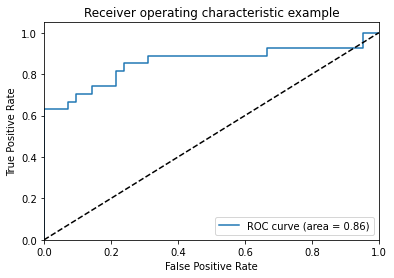

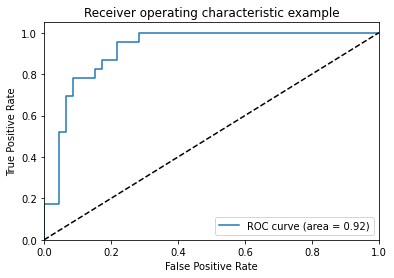

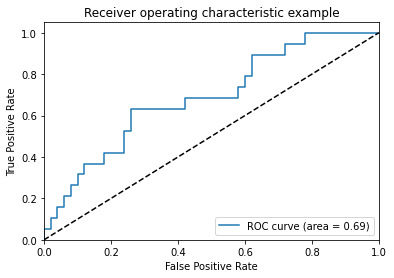

In [ ]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)


0.7441539436352556

In [ ]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[32 10]
  [ 4 23]]

 [[27 19]
  [ 0 23]]

 [[29 21]
  [ 6 13]]]
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        27
           1       0.55      1.00      0.71        23
           2       0.38      0.68      0.49        19

   micro avg       0.54      0.86      0.66        69
   macro avg       0.54      0.85      0.65        69
weighted avg       0.56      0.86      0.67        69
 samples avg       0.62      0.86      0.70        69



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.6183574879227054


In [ ]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.391304347826087
Hamming loss: 0.2898550724637681


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[23,  3,  1],
       [ 2, 21,  0],
       [ 8,  9,  2]])

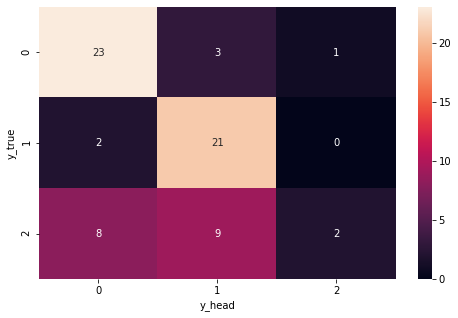

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

#Sinovac LSTM-ADAM

In [53]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = LSTM(200, activation='tanh', return_sequences = True, dropout=0.4)(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 - 6s - loss: 0.7031 - accuracy: 0.3187 - val_loss: 0.6626 - val_accuracy: 0.3768

 ROC-AUC - epoch: 1 - score: 0.555211 

Epoch 2/100
9/9 - 3s - loss: 0.6537 - accuracy: 0.3553 - val_loss: 0.6369 - val_accuracy: 0.3913

 ROC-AUC - epoch: 2 - score: 0.566383 

Epoch 3/100
9/9 - 2s - loss: 0.6408 - accuracy: 0.4029 - val_loss: 0.6281 - val_accuracy: 0.3913

 ROC-AUC - epoch: 3 - score: 0.632061 

Epoch 4/100
9/9 - 3s - loss: 0.6206 - accuracy: 0.4799 - val_loss: 0.5800 - val_accuracy: 0.5942

 ROC-AUC - epoch: 4 - score: 0.735414 

Epoch 5/100
9/9 - 2s - loss: 0.6041 - accuracy: 0.4725 - val_loss: 0.5628 - val_accuracy: 0.5217

 ROC-AUC - epoch: 5 - score: 0.751836 

Epoch 6/100
9/9 - 3s - loss: 0.5872 - accuracy: 0.5165 - val_loss: 0.5430 - val_accuracy: 0.6087

 ROC-AUC - epoch: 6 - score: 0.782786 

Epoch 7/100
9/9 - 3s - loss: 0.5672 - accuracy: 0.5385 - val_loss: 0.5413 - val_accuracy: 0.5797

 ROC-AUC - epoch: 7 - score: 0.796894 

Epoch 8/100
9/9 - 2s - loss: 0.544

In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           338700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 200)           400800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

In [55]:
from keras.models import load_model
c = model.predict(X_te)

In [56]:

score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 41ms/step - loss: 1.1266 - accuracy: 0.7246
Test accuracy: 0.7246376872062683


In [57]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.8837673029220582

In [58]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

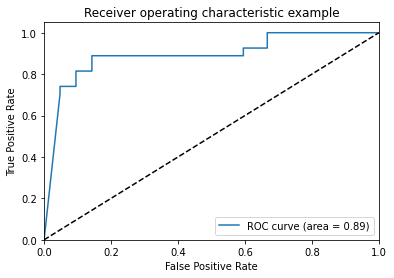

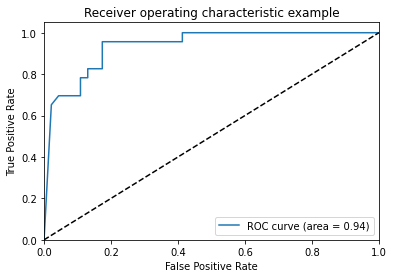

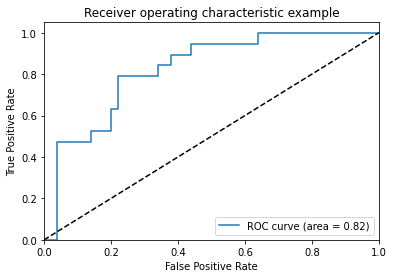

In [59]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [60]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)


0.79198164493359

In [61]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[36  6]
  [ 3 24]]

 [[38  8]
  [ 4 19]]

 [[44  6]
  [10  9]]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.70      0.83      0.76        23
           2       0.60      0.47      0.53        19

   micro avg       0.72      0.75      0.74        69
   macro avg       0.70      0.73      0.71        69
weighted avg       0.71      0.75      0.73        69
 samples avg       0.74      0.75      0.74        69



In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.7391304347826086


In [63]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.7246376811594203
Hamming loss: 0.178743961352657


In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[24,  1,  2],
       [ 1, 19,  3],
       [ 5,  5,  9]])

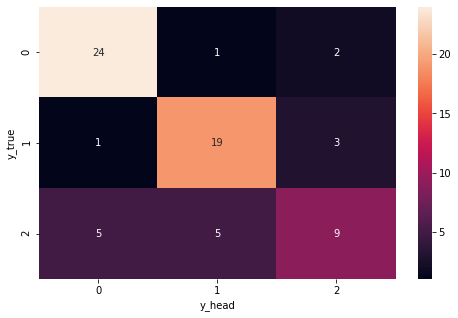

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [66]:
df_untagged = df_untagged.drop(['tag'], axis =1)
df_untagged

,Name,Comments
0,ica_risa18,@indriaelvandria bacee
1,djulkifli_,Aku tak ngguyu mbek turu😂😂😂😄😄
2,bagja.rki,@chaeny_shoftyani
3,pentolisme,@slebewwww @ripalbendot
4,ar_balance01,@randyahmd22
...,...,...
517,_balaa._syahiddtu,halal blm tentu baik ?
518,tomijumaesa,Masyarakat Cina di vaksin gk sih min???
519,07_arif,kita sinovac sendiri lohh? beranii? 🤣
520,arisadwicahyo,"Emang udah tau bahan dalem nya apa aja😁,dibuat..."


In [67]:
#ilangin link dan uname
df_untagged["Comments"]=df_untagged["Comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df_untagged["Comments"]=df_untagged["Comments"].str.lower()
#ilangin simbol
df_untagged["Comments"]=df_untagged["Comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df_untagged["Comments"]=df_untagged["Comments"].str.replace('\d+',' ')
#ilangin enter
df_untagged["Comments"]=df_untagged["Comments"].str.replace('\n',' ',regex=True)
df_untagged["Comments"] = df_untagged["Comments"].replace('\s+', ' ', regex=True)
df_untagged

,Name,Comments
0,ica_risa18,bacee
1,djulkifli_,aku tak ngguyu mbek turu
2,bagja.rki,
3,pentolisme,
4,ar_balance01,
...,...,...
517,_balaa._syahiddtu,halal blm tentu baik
518,tomijumaesa,masyarakat cina di vaksin gk sih min
519,07_arif,kita sinovac sendiri lohh beranii
520,arisadwicahyo,emang udah tau bahan dalem nya apa aja dibuat ...


In [68]:
list_sentences_aplikasi = df_untagged["Comments"]
list_tokenized_aplikasi = tokenizer.texts_to_sequences(list_sentences_aplikasi)
X_aplikasi = pad_sequences(list_tokenized_aplikasi, maxlen=maxlen)
X_aplikasi

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,  123,  775],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,   12,    5,   74],
       [   0,    0,    0, ...,   46,  438,  133],
       [   0,    0,    0, ...,  191, 1055,  125]], dtype=int32)

In [69]:
y_pred_aplikasi = model.predict(X_aplikasi)
y_pred_aplikasi


array([[3.7140178e-04, 3.6394406e-02, 9.6323419e-01],
       [3.4886098e-04, 9.9827039e-01, 1.3806545e-03],
       [3.7140178e-04, 3.6394406e-02, 9.6323419e-01],
       ...,
       [9.5931432e-09, 1.0000000e+00, 2.8350189e-09],
       [5.5534799e-10, 1.1236990e-09, 1.0000000e+00],
       [9.9951494e-01, 3.8365211e-04, 1.0142504e-04]], dtype=float32)

In [70]:
dfhasil = pd.DataFrame(y_pred_aplikasi, columns=['POS', 'NET', 'NEG'])
dfhasil

,POS,NET,NEG
0,3.714018e-04,3.639441e-02,9.632342e-01
1,3.488610e-04,9.982704e-01,1.380655e-03
2,3.714018e-04,3.639441e-02,9.632342e-01
3,3.714018e-04,3.639441e-02,9.632342e-01
4,3.714018e-04,3.639441e-02,9.632342e-01
...,...,...,...
517,9.284927e-10,1.000000e+00,1.565980e-10
518,2.693339e-04,6.065704e-07,9.997301e-01
519,9.593143e-09,1.000000e+00,2.835019e-09
520,5.553480e-10,1.123699e-09,1.000000e+00


In [71]:
dfhasilramal = dfhasil.eq(dfhasil.where(dfhasil != 0).max(1), axis=0).astype(int)
dfhasilramal

,POS,NET,NEG
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
517,0,1,0
518,0,0,1
519,0,1,0
520,0,0,1


In [72]:
finalresult = pd.concat([df_untagged, dfhasilramal], axis=1, sort=False)
finalresult

,Name,Comments,POS,NET,NEG
0,ica_risa18,bacee,0,0,1
1,djulkifli_,aku tak ngguyu mbek turu,0,1,0
2,bagja.rki,,0,0,1
3,pentolisme,,0,0,1
4,ar_balance01,,0,0,1
...,...,...,...,...,...
517,_balaa._syahiddtu,halal blm tentu baik,0,1,0
518,tomijumaesa,masyarakat cina di vaksin gk sih min,0,0,1
519,07_arif,kita sinovac sendiri lohh beranii,0,1,0
520,arisadwicahyo,emang udah tau bahan dalem nya apa aja dibuat ...,0,0,1


In [73]:
finalresult.POS.value_counts()

0    413
1    109
Name: POS, dtype: int64

In [74]:
finalresult.NET.value_counts()

0    369
1    153
Name: NET, dtype: int64

In [75]:
finalresult.NEG.value_counts()

0    262
1    260
Name: NEG, dtype: int64